### Requirements (to-do-list)
CHECK --> Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

CHECK --> Apply a distortion correction to raw images.

Use color transforms, gradients, etc., to create a thresholded binary image.

Apply a perspective transform to rectify binary image ("birds-eye view").

Detect lane pixels and fit to find the lane boundary.

Determine the curvature of the lane and vehicle position with respect to center.

Warp the detected lane boundaries back onto the original image.

Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
#%matplotlib inline
%matplotlib qt

In [3]:
images = glob.glob('./camera_cal/calibration*.jpg')

#coordinates of the board corners
objpoints = []
imgpoints = []
COLUMNS_TO_FIND = 6
objp = np.zeros((COLUMNS_TO_FIND*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:COLUMNS_TO_FIND].T.reshape(-1,2)

    
for fname in images:
    
    img = mpimg.imread(fname)    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret,corners = cv2.findChessboardCorners(gray, (9,COLUMNS_TO_FIND),None)
    
    if ret == True:    
        imgpoints.append(corners)
        objpoints.append(objp)

        #img = cv2.drawChessboardCorners(img, (9,5), corners, ret)
        
        #print("corners 0 0 ", corners[0][0])
        #print(len(corners),corners, ret)

### Below returns distortion coef, camera matrix, rotation vec, translation vec 

In [4]:
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None, None)

In [5]:
img = mpimg.imread('./camera_cal\\calibration1.jpg')
undist = np.copy(img)
gray = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)
undistorted = cv2.undistort(gray, mtx, dist, None, mtx)

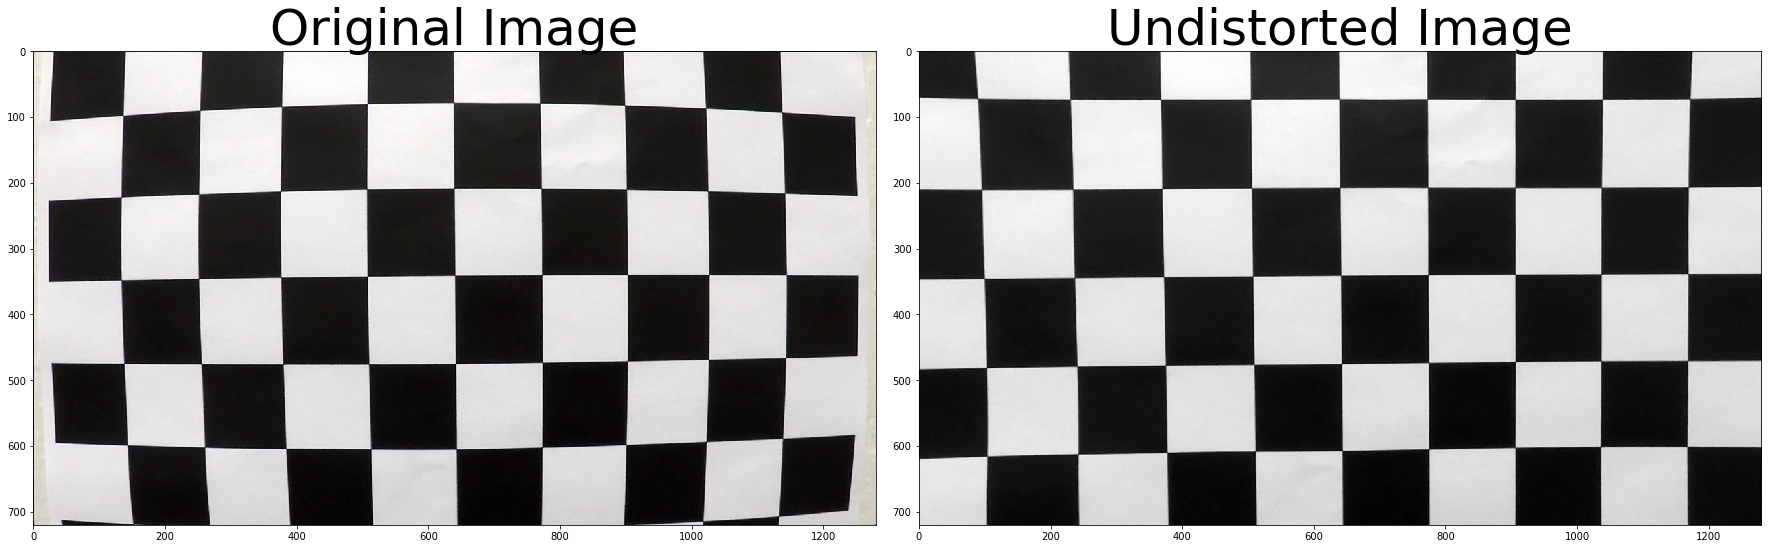

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted,cmap='gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Histogram on 33. Finding the Lanes

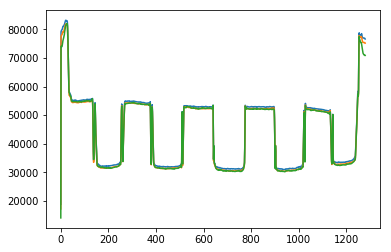

In [7]:
import numpy as np
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)